In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-of-aquatic-animals/aquatic_animals/shark/image_153.jpeg
/kaggle/input/dataset-of-aquatic-animals/aquatic_animals/shark/image_173.jpeg
/kaggle/input/dataset-of-aquatic-animals/aquatic_animals/shark/image_182.jpeg
/kaggle/input/dataset-of-aquatic-animals/aquatic_animals/shark/image_161.jpeg
/kaggle/input/dataset-of-aquatic-animals/aquatic_animals/shark/image_159.jpeg
/kaggle/input/dataset-of-aquatic-animals/aquatic_animals/shark/image_168.jpeg
/kaggle/input/dataset-of-aquatic-animals/aquatic_animals/shark/image_186.jpeg
/kaggle/input/dataset-of-aquatic-animals/aquatic_animals/shark/image_175.jpeg
/kaggle/input/dataset-of-aquatic-animals/aquatic_animals/shark/image_155.jpeg
/kaggle/input/dataset-of-aquatic-animals/aquatic_animals/shark/image_170.jpeg
/kaggle/input/dataset-of-aquatic-animals/aquatic_animals/shark/image_154.jpeg
/kaggle/input/dataset-of-aquatic-animals/aquatic_animals/shark/image_199.jpeg
/kaggle/input/dataset-of-aquatic-animals/aquatic_animals/shark/i

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load Data

In [3]:
root_dir = "../input/dataset-of-aquatic-animals/aquatic_animals/"
folders = os.listdir(root_dir)
folders

['shark',
 'seaturtle',
 'starfish',
 'seal',
 'octopus',
 'crab',
 'seahorse',
 'dolphin']

In [4]:
data = []
img_paths = []
labels = []

for label in folders:
    path = f'{root_dir}/{label}/'
    folder_data = os.listdir(path)
    for image_path in folder_data:
        img_path = os.path.join(path, image_path)
        img = cv2.imread(path + image_path)
        img = cv2.resize(img, (224, 224))
        data.append(np.array(img))
        labels.append(label)
        img_paths.append(img_path)

In [5]:
data = np.array(data)
labels = np.array(labels)
img_paths = np.array(img_paths)

In [6]:
data.shape, labels.shape, img_paths.shape

((400, 224, 224, 3), (400,), (400,))

In [7]:
df = pd.DataFrame({"Path": img_paths, "Label": labels})
df.head()

,Path,Label
0,../input/dataset-of-aquatic-animals/aquatic_an...,shark
1,../input/dataset-of-aquatic-animals/aquatic_an...,shark
2,../input/dataset-of-aquatic-animals/aquatic_an...,shark
3,../input/dataset-of-aquatic-animals/aquatic_an...,shark
4,../input/dataset-of-aquatic-animals/aquatic_an...,shark


In [8]:
def visualize_df(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    
    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            img_path = df.sample(frac=1).iloc[i]["Path"]
            label = df.sample(frac=1).iloc[i]["Label"]
            
            img = plt.imread(img_path)
            ax.imshow(img)
            ax.set_title(label)
            ax.axis("off")
        else:
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()

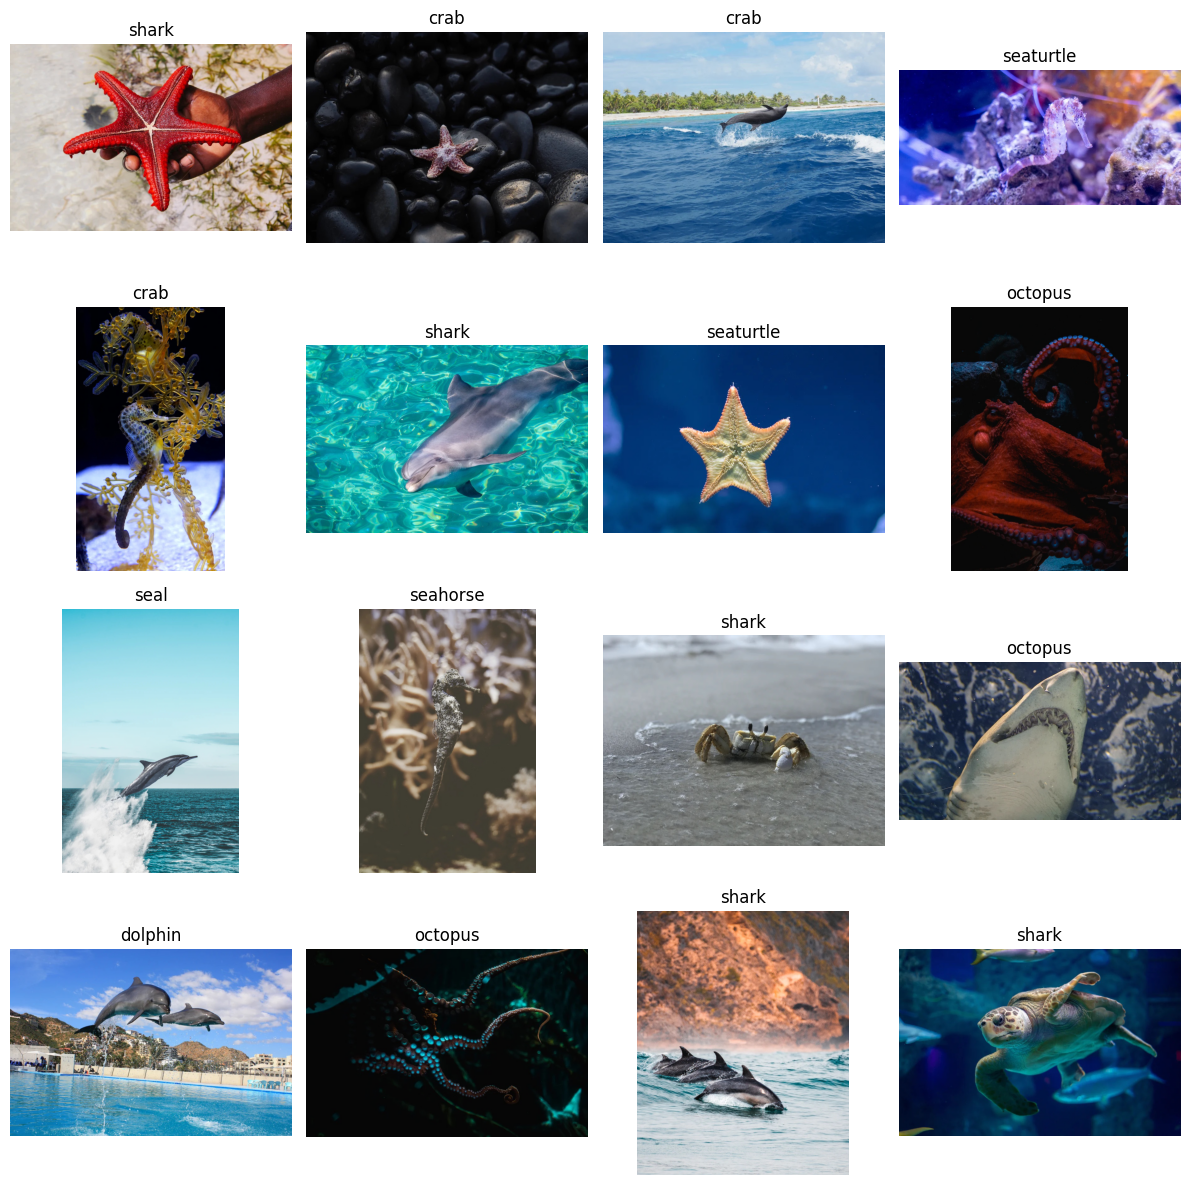

In [9]:
visualize_df(df)

# MobileNetV2

In [10]:
df = pd.DataFrame({"file_path": img_paths, "label": labels})
df.head()

,file_path,label
0,../input/dataset-of-aquatic-animals/aquatic_an...,shark
1,../input/dataset-of-aquatic-animals/aquatic_an...,shark
2,../input/dataset-of-aquatic-animals/aquatic_an...,shark
3,../input/dataset-of-aquatic-animals/aquatic_an...,shark
4,../input/dataset-of-aquatic-animals/aquatic_an...,shark


In [11]:
df.shape

(400, 2)

In [12]:
train_data = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=45,
    fill_mode="nearest"
)

test_data = ImageDataGenerator(
    rescale=1./255
)

valid_data = ImageDataGenerator(
    rescale=1./255
)

In [13]:
def train_validate_test_split(df):
    np.random.seed(42)
    perm = np.random.permutation(df.index)
    train_end = int(.8 * len(df.index))
    validate_end = int(.1 * len(df.index)) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

df_train, df_validation, df_test = train_validate_test_split(df)
print(len(df_train), len(df_validation), len(df_test))

320 40 40


In [14]:
train_gen = train_data.flow_from_dataframe(
    dataframe=df_train,
    x_col="file_path",
    y_col="label",
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224),
)

valid_gen = valid_data.flow_from_dataframe(
    dataframe=df_validation,
    x_col="file_path",
    y_col="label",
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224),
)

test_gen = test_data.flow_from_dataframe(
    dataframe=df_test,
    x_col="file_path",
    y_col=None,
    batch_size=32,
    shuffle=True,
    class_mode=None,
    target_size=(224, 224),
)

Found 320 validated image filenames belonging to 8 classes.
Found 40 validated image filenames belonging to 8 classes.
Found 40 validated image filenames.


In [15]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [16]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(8, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [17]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [18]:
callbacks = [EarlyStopping(monitor="val_loss", patience=5)]

In [27]:
history = model.fit(
    train_gen, 
    steps_per_epoch=train_gen.samples // train_gen.batch_size, 
    epochs=50, 
    validation_data=valid_gen, 
    validation_steps=valid_gen.samples // valid_gen.batch_size,
)

Epoch 1/50
10/10 [==============================] - 6s 578ms/step - loss: 0.0596 - accuracy: 0.9781 - val_loss: 0.3062 - val_accuracy: 0.9062
Epoch 2/50
10/10 [==============================] - 6s 580ms/step - loss: 0.0407 - accuracy: 0.9875 - val_loss: 0.4664 - val_accuracy: 0.8750
Epoch 3/50
10/10 [==============================] - 6s 578ms/step - loss: 0.0269 - accuracy: 0.9906 - val_loss: 0.1483 - val_accuracy: 0.9062
Epoch 4/50
10/10 [==============================] - 6s 567ms/step - loss: 0.0267 - accuracy: 0.9906 - val_loss: 0.2163 - val_accuracy: 0.9375
Epoch 5/50
10/10 [==============================] - 6s 585ms/step - loss: 0.0371 - accuracy: 0.9844 - val_loss: 0.5411 - val_accuracy: 0.8438
Epoch 6/50
10/10 [==============================] - 6s 582ms/step - loss: 0.0272 - accuracy: 0.9875 - val_loss: 0.4670 - val_accuracy: 0.8438
Epoch 7/50
10/10 [==============================] - 6s 585ms/step - loss: 0.0135 - accuracy: 0.9937 - val_loss: 0.3588 - val_accuracy: 0.8438
Epoch 

In [29]:
#model.save("aquatic-animals.h5")

In [30]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.059622,0.978125,0.306163,0.90625
1,0.040677,0.987500,0.466450,0.87500
2,0.026883,0.990625,0.148329,0.90625
3,0.026694,0.990625,0.216299,0.93750
4,0.037135,0.984375,0.541089,0.84375


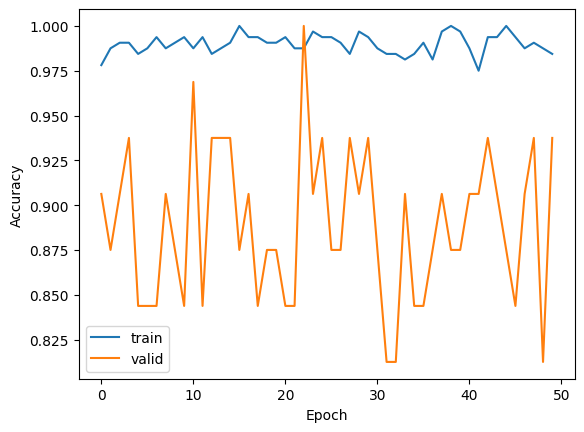

In [31]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "valid"])
plt.show()

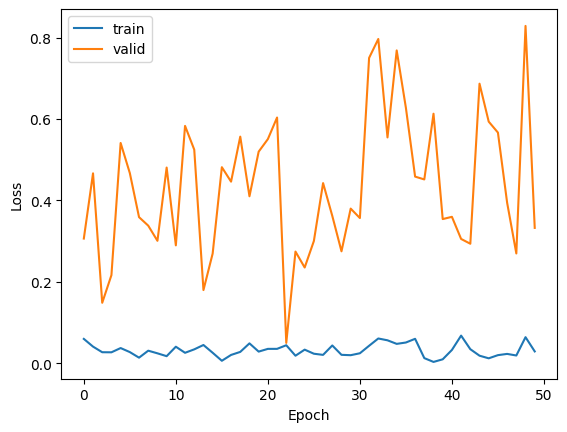

In [32]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "valid"])
plt.show()

In [33]:
test_loss, test_acc = model.evaluate(valid_gen)
print('Test accuracy:', test_acc)

2/2 [==============================] - 0s 42ms/step - loss: 0.5266 - accuracy: 0.9000
Test accuracy: 0.8999999761581421
